<a href="https://colab.research.google.com/github/SayatAbdikul/animal_classification_model/blob/main/animal_classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Getting the data

In [2]:
import os
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
import torch
from torch.utils.data import DataLoader, random_split
from torchvision import datasets, transforms
from torchvision.datasets import ImageFolder


In [4]:
image_size = 224
transform = transforms.Compose([
    transforms.RandomResizedCrop(224),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])
folder_path = '/content/drive/My Drive/animal_images'
dataset = ImageFolder(root=folder_path, transform=transform)
train_size = int(0.7 * len(dataset))
val_size = int(0.15 * len(dataset))
test_size = len(dataset) - train_size - val_size
train_data, val_data, test_data = random_split(dataset, [train_size, val_size, test_size])

In [5]:
dataset.classes

['Abyssinian',
 'Bengal',
 'american_bulldog',
 'american_pit_bull_terrier',
 'basset_hound']

In [6]:
train_dataloader = DataLoader(train_data, batch_size=32, shuffle=True)
val_dataloader = DataLoader(val_data, batch_size=32, shuffle=False)
test_dataloader = DataLoader(test_data, batch_size=32, shuffle=False)

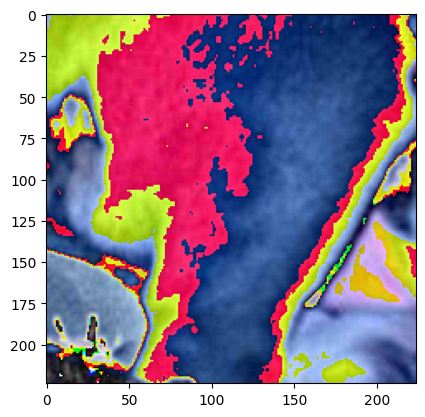

In [7]:
import matplotlib.pyplot as plt
image = next(iter(train_dataloader))[0][0]
to_pil = transforms.ToPILImage()
plt.imshow(to_pil(image))
plt.show()

# Helper functions

In [8]:
def accuracy_fn(y_true, y_pred):
    correct = torch.eq(y_true, y_pred).sum().item()
    acc = (correct / len(y_pred)) * 100
    return acc

In [9]:
def train_step(model: torch.nn.Module,
               dataloader: torch.utils.data.DataLoader,
               loss_fn: torch.nn.Module,
               optimizer: torch.optim.Optimizer,
               device: torch.device) -> float:
    model.train()
    train_loss, train_acc = 0, 0
    for batch, (X, y) in enumerate(dataloader):
        X, y = X.to(device), y.to(device)
        if len(X) == 0:
            print(f"empty batch on {batch}")
            continue
        y_pred = model(X)
        loss = loss_fn(y_pred, y)
        train_loss += loss.item()
        train_acc += accuracy_fn(y_true=y, y_pred=y_pred.argmax(dim=1))
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        if batch % 10 == 0:
          print(f"looked at batch: {batch}/ {len(dataloader)}")
    print(f"Train loss: {train_loss/len(train_dataloader):.5f} | Train accuracy: {train_acc/len(train_dataloader):.2f}%")

In [15]:
def evaluation_step(model: torch.nn.Module,
                    dataloader: torch.utils.data.DataLoader,
                    loss_fn: torch.nn.Module,
                    device: torch.device) -> float:
    model.eval()
    with torch.inference_mode():
        eval_loss, eval_acc = 0, 0
        for batch, (X, y) in enumerate(dataloader):
            X, y = X.to(device), y.to(device)
            if len(X) == 0:
                print(f"empty batch on {batch}")
                continue
            y_pred = model(X)
            loss = loss_fn(y_pred, y)
            eval_loss += loss.item()
            eval_acc += accuracy_fn(y_true=y, y_pred=y_pred.argmax(dim=1))
        print(f"Model loss: {eval_loss/len(val_dataloader):.5f} | Model accuracy: {eval_acc/len(val_dataloader):.2f}%")

# Pre-trained B0 model

In [1]:
import torchvision
from torchvision import models
trained_model = models.efficientnet_b0(pretrained=True)
trained_model

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=EfficientNet_B0_Weights.IMAGENET1K_V1`. You can also use `weights=EfficientNet_B0_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/efficientnet_b0_rwightman-7f5810bc.pth" to /root/.cache/torch/hub/checkpoints/efficientnet_b0_rwightman-7f5810bc.pth
100%|██████████| 20.5M/20.5M [00:00<00:00, 33.4MB/s]


EfficientNet(
  (features): Sequential(
    (0): Conv2dNormActivation(
      (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): SiLU(inplace=True)
    )
    (1): Sequential(
      (0): MBConv(
        (block): Sequential(
          (0): Conv2dNormActivation(
            (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
            (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
            (2): SiLU(inplace=True)
          )
          (1): SqueezeExcitation(
            (avgpool): AdaptiveAvgPool2d(output_size=1)
            (fc1): Conv2d(32, 8, kernel_size=(1, 1), stride=(1, 1))
            (fc2): Conv2d(8, 32, kernel_size=(1, 1), stride=(1, 1))
            (activation): SiLU(inplace=True)
            (scale_activation): Sigmoid()
          )
          (2): Conv2dNormActivat

In [14]:
epochs = 3
device = 'cuda' if torch.cuda.is_available() else 'cpu'
trained_model.to(device)
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(params=trained_model.parameters(), lr=0.1)
for epoch in range(epochs):
    print(f"Epoch: {epoch}\n---------")
    train_step(model=trained_model, dataloader=train_dataloader, loss_fn=loss_fn, optimizer=optimizer, device=device)
    evaluation_step(model=trained_model, dataloader=val_dataloader, loss_fn=loss_fn, device=device)

Epoch: 0
---------
looked at batch: 0/ 27
looked at batch: 10/ 27
looked at batch: 20/ 27
Train loss: 1.88594 | Train accuracy: 61.53%
Validation loss: 0.71975 | Validation acc: 75.54%
Epoch: 1
---------
looked at batch: 0/ 27
looked at batch: 10/ 27
looked at batch: 20/ 27
Train loss: 0.56615 | Train accuracy: 82.16%
Validation loss: 0.63526 | Validation acc: 80.64%
Epoch: 2
---------
looked at batch: 0/ 27
looked at batch: 10/ 27
looked at batch: 20/ 27
Train loss: 0.46595 | Train accuracy: 86.28%
Validation loss: 0.55399 | Validation acc: 78.15%


In [16]:
evaluation_step(model=trained_model, dataloader=test_dataloader, loss_fn=loss_fn, device=device)

Model loss: 0.61415 | Model accuracy: 83.79%


# Baseline model without convolution


In [11]:
from torch import nn

class BaselineModel(nn.Module):
    def __init__(self, input_shape: int, hidden_units: int, output_shape: int):
        super().__init__()
        self.layer_stack = nn.Sequential(
            nn.Flatten(),
            nn.Linear(in_features=input_shape, out_features=hidden_units),
            nn.ReLU(),
            nn.Linear(in_features=hidden_units, out_features=hidden_units),
            nn.ReLU(),
            nn.Linear(in_features=hidden_units, out_features=output_shape),
            nn.ReLU()
        )

    def forward(self, x):
        return self.layer_stack(x)

In [12]:
model_0 = BaselineModel(input_shape=3*image_size*image_size, hidden_units=10, output_shape=5)
model_0

BaselineModel(
  (layer_stack): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=150528, out_features=10, bias=True)
    (2): ReLU()
    (3): Linear(in_features=10, out_features=10, bias=True)
    (4): ReLU()
    (5): Linear(in_features=10, out_features=5, bias=True)
    (6): ReLU()
  )
)

In [13]:
torch.manual_seed(7)
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(params=model_0.parameters(), lr=0.1)
epochs = 3
device = 'cuda' if torch.cuda.is_available() else 'cpu'
model_0.to(device)
for epoch in range(epochs):
    print(f"Epoch: {epoch}\n---------")
    train_step(model=model_0, dataloader=train_dataloader, loss_fn=loss_fn, optimizer=optimizer, device=device)
    evaluation_step(model=model_0, dataloader=val_dataloader, loss_fn=loss_fn, device=device)

Epoch: 0
---------


ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.



Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/IPython/core/interactiveshell.py", line 3553, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-13-72ea70607cd4>", line 9, in <cell line: 7>
    train_step(model=model_0, dataloader=train_dataloader, loss_fn=loss_fn, optimizer=optimizer, device=device)
  File "<ipython-input-9-e8a3c5ea0e75>", line 8, in train_step
    for batch, (X, y) in enumerate(dataloader):
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 631, in __next__
    data = self._next_data()
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 675, in _next_data
    data = self._dataset_fetcher.fetch(index)  # may raise StopIteration
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/_utils/fetch.py", line 49, in fetch
    data = self.dataset.__getitems__(possibly_batched_index)
  File "/usr/local/lib/python3.10/dist-pac

TypeError: object of type 'NoneType' has no len()

# EfficientNet-B0

## Creating the model

In [ ]:
class MBConvBlock(nn.Module):
    def __init__(self, in_channels: int, out_channels: int, stride: int, expansion: int):
        super(MBConvBlock, self).__init__()

        self.use_residual = (in_channels == out_channels) and (stride == 1)

        hidden_dim = in_channels * expansion
        layers = []

        # Expansion phase
        if expansion != 1:
            layers.append(nn.Conv2d(in_channels, hidden_dim, kernel_size=1, bias=False))
            layers.append(nn.BatchNorm2d(hidden_dim))
            layers.append(nn.ReLU(inplace=True))

        # Depthwise convolution phase
        layers.append(nn.Conv2d(hidden_dim, hidden_dim, kernel_size=3, stride=stride, padding=1, groups=hidden_dim, bias=False))
        layers.append(nn.BatchNorm2d(hidden_dim))
        layers.append(nn.ReLU(inplace=True))

        # Pointwise-linear phase
        layers.append(nn.Conv2d(hidden_dim, out_channels, kernel_size=1, bias=False))
        layers.append(nn.BatchNorm2d(out_channels))

        self.conv = nn.Sequential(*layers)

    def forward(self, x):
        if self.use_residual:
            return x + self.conv(x)
        else:
            return self.conv(x)

In [ ]:
class EfficientNetB0(nn.Module):
    def __init__(self, num_classes=1000):
        super(EfficientNetB0, self).__init__()
        self.stem = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=3, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(32),
            nn.ReLU(inplace=True),
            nn.Conv2d(32, 32, kernel_size=3, stride=1, padding=1, bias=False),
            nn.BatchNorm2d(32),
            nn.ReLU(inplace=True),
            nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1, bias=False),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2, padding=1)
        )
        self.blocks = nn.Sequential(
            MBConvBlock(in_channels=64, out_channels=16, expansion=1, stride=1),
            MBConvBlock(in_channels=16, out_channels=24, expansion=6, stride=2),
            MBConvBlock(in_channels=24, out_channels=40, expansion=6, stride=2),
            MBConvBlock(in_channels=40, out_channels=80, expansion=6, stride=2),
            MBConvBlock(in_channels=80, out_channels=112, expansion=6, stride=1),
            MBConvBlock(in_channels=112, out_channels=192, expansion=6, stride=2),
            MBConvBlock(in_channels=192, out_channels=320, expansion=6, stride=1)
        )
        self.head = nn.Sequential(
            nn.Conv2d(320, 1280, kernel_size=1, stride=1, padding=0, bias=False),
            nn.BatchNorm2d(1280),
            nn.ReLU(inplace=True),
            nn.AdaptiveAvgPool2d(1)
        )
        self.fc = nn.Linear(1280, num_classes)

    def forward(self, x):
        x = self.stem(x)
        x = self.blocks(x)
        x = self.head(x)
        x = x.view(x.size(0), -1)
        x = self.fc(x)
        return x

## Training the model

In [ ]:
model_1 = EfficientNetB0(num_classes=5)
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(params=model_1.parameters(), lr=0.1)
epochs = 3
device = 'cuda' if torch.cuda.is_available() else 'cpu'
model_1.to(device)

In [ ]:
torch.manual_seed(7)
epochs = 10
for epoch in range(epochs):
    print(f"Epoch: {epoch}\n---------")
    train_step(model=model_1, dataloader=train_dataloader, loss_fn=loss_fn, optimizer=optimizer, device=device)
    evaluation_step(model=model_1, dataloader=val_dataloader, loss_fn=loss_fn, device=device)